In [1]:
import torch
from SingleSessionSingleTrialDataset_OtherWay_Transformer import SingleSessionSingleTrialDataset_OtherWay
import numpy as np
from pynwb import NWBHDF5IO

import os

dataset_path = "000070"
nwb_file_path = os.path.join(
    dataset_path, "sub-Jenkins", "sub-Jenkins_ses-20090916_behavior+ecephys.nwb")
io = NWBHDF5IO(nwb_file_path, 'r')
nwb_file = io.read()
hand_data = nwb_file.processing['behavior'].data_interfaces['Position']['Hand'].data[:]
hand_timestamps = nwb_file.processing['behavior'].data_interfaces['Position']['Hand'].timestamps[:]
trial_data = nwb_file.intervals['trials']

unit_spike_times = [nwb_file.units[unit_id]['spike_times'].iloc[0][:]
                    for unit_id in range(len(nwb_file.units))]
n_neurons = len(unit_spike_times)
n_context_bins = 20

n_trials = 200
datasets = [SingleSessionSingleTrialDataset_OtherWay(
    trial_data, hand_data, hand_timestamps, unit_spike_times, trial_id, bin_size=0.02, n_context_bins=n_context_bins) for trial_id in range(n_trials)]
dataset = torch.utils.data.ConcatDataset(datasets)
print(f"Dataset from {n_trials} trials has {len(dataset)} samples")

/home/dima/code/marvin/venv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/dima/code/marvin/venv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Dataset from 200 trials has 1071 samples


In [2]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert dataset to PyTorch tensors and move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X = []
for i in range(len(dataset)):
    features = dataset[i]
    X.append(features)
X = torch.stack(X).to(device)

# Split into train/test
split_idx = int(0.9 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

X_train shape: torch.Size([963, 196, 20]) X_test shape: torch.Size([108, 196, 20])


In [6]:
n_fr_bins = 9

# Create data loaders
train_dataset = TensorDataset(X_train)
test_dataset = TensorDataset(X_test)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200)

# Define model
input_size = (n_neurons+4)
hidden_size = 1024

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, n_neurons, n_fr_bins):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Input linear layer
        self.input_linear = nn.Linear(input_size, hidden_size)
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=3,
            batch_first=True,
            dropout=0.1
        )
        
        # Output layers
        self.output_linear = nn.Linear(hidden_size, n_neurons * n_fr_bins)
        self.unflatten = nn.Unflatten(2, (n_neurons, n_fr_bins))

    def forward(self, x):
        batch_size, n_context_bins, n_features = x.shape
        
        # Initial linear projection
        x = self.input_linear(x)
        
        # LSTM processing
        x, _ = self.lstm(x)
        
        # Output processing
        x = self.output_linear(x)
        x = self.unflatten(x)
        return x

model = LSTMModel(input_size, hidden_size, n_neurons, n_fr_bins).to(device)

In [7]:
# Training parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
n_epochs = 50

# Training loop
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for batch_X in train_loader:
        batch_X = batch_X[0] # shape: (batch_size, n_neurons+4, n_context_bins)
        batch_X = batch_X.transpose(1, 2) # shape: (batch_size, n_context_bins, n_neurons+4)
        batch_y = batch_X[:, 1:, :n_neurons].clone().long().to(device) # shape: (batch_size, n_context_bins-1, n_neurons)
        batch_X = batch_X.clone().to(device)
        #batch_X += torch.randn_like(batch_X) * 0.2
        batch_X = batch_X[:, :-1, :] # shape: (batch_size, n_context_bins-1, n_neurons+4)
        
        optimizer.zero_grad()
        outputs = model(batch_X)[:, :n_neurons, :, :]  # Shape: (batch, n_context_bins-1, n_neurons, n_fr_bins)
        loss = criterion(outputs.reshape(-1, n_fr_bins), batch_y.reshape(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch_X in test_loader:
            batch_X = batch_X[0]  # shape: (batch_size, n_neurons+4, n_context_bins)
            batch_X = batch_X.transpose(1, 2)  # shape: (batch_size, n_context_bins, n_neurons+4)
            batch_X = batch_X.to(device)
            batch_y = batch_X[:, 1:, :n_neurons].clone().long()  # shape: (batch_size, n_context_bins-1, n_neurons)
            batch_X = batch_X[:, :-1, :]  # shape: (batch_size, n_context_bins-1, n_neurons+4)
            
            outputs = model(batch_X)[:, :n_neurons, :, :]  # Shape: (batch, n_context_bins-1, n_neurons, n_fr_bins)
            
            # Get predicted classes
            pred_classes = torch.argmax(outputs, dim=3)  # Shape: (batch, n_context_bins-1, n_neurons)
            
            # Calculate accuracy
            acc = (pred_classes == batch_y).float().mean()
            
            # Calculate per-neuron accuracies
            acc_per_neuron = [(pred_classes[:, :, i] == batch_y[:, :, i]).float().mean() for i in range(n_neurons)]
            
            # Average accuracy for first and second half of neurons
            acc_first = sum(acc_per_neuron[:n_neurons//2])/len(acc_per_neuron[:n_neurons//2])
            acc_second = sum(acc_per_neuron[n_neurons//2:])/len(acc_per_neuron[n_neurons//2:])
            
            val_loss += criterion(outputs.reshape(-1, n_fr_bins), batch_y.reshape(-1))
            
        train_acc = acc  # Using last batch accuracy as proxy
        test_acc = acc
        train_acc_first = acc_first
        train_acc_second = acc_second
        test_acc_first = acc_first 
        test_acc_second = acc_second
        val_loss_mean = val_loss / len(test_loader)
    
    if (epoch + 1) % 1 == 0:
        print(f"\nEpoch {epoch+1}/{n_epochs} | Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f} | Val Loss: {val_loss_mean:.3f}")
        print(f"\t\tTrain Acc (1st/2nd half): ({train_acc_first:.3f}, {train_acc_second:.3f}) | Test Acc (1st/2nd half): ({test_acc_first:.3f}, {test_acc_second:.3f})")



Epoch 1/50 | Train Acc: 0.480 | Test Acc: 0.480 | Val Loss: 1.277
		Train Acc (1st/2nd half): (0.505, 0.454) | Test Acc (1st/2nd half): (0.505, 0.454)

Epoch 2/50 | Train Acc: 0.481 | Test Acc: 0.481 | Val Loss: 1.173
		Train Acc (1st/2nd half): (0.506, 0.456) | Test Acc (1st/2nd half): (0.506, 0.456)

Epoch 3/50 | Train Acc: 0.486 | Test Acc: 0.486 | Val Loss: 1.154
		Train Acc (1st/2nd half): (0.509, 0.462) | Test Acc (1st/2nd half): (0.509, 0.462)

Epoch 4/50 | Train Acc: 0.486 | Test Acc: 0.486 | Val Loss: 1.149
		Train Acc (1st/2nd half): (0.510, 0.462) | Test Acc (1st/2nd half): (0.510, 0.462)

Epoch 5/50 | Train Acc: 0.486 | Test Acc: 0.486 | Val Loss: 1.151
		Train Acc (1st/2nd half): (0.510, 0.463) | Test Acc (1st/2nd half): (0.510, 0.463)

Epoch 6/50 | Train Acc: 0.487 | Test Acc: 0.487 | Val Loss: 1.153
		Train Acc (1st/2nd half): (0.511, 0.463) | Test Acc (1st/2nd half): (0.511, 0.463)

Epoch 7/50 | Train Acc: 0.487 | Test Acc: 0.487 | Val Loss: 1.157
		Train Acc (1st/2nd 

In [100]:
# Training with teacher forcing for 5 steps
model.train()
n_steps = 5  # Number of consecutive steps to predict
temperature = 1.0

for epoch in range(n_epochs):
    train_loss = 0
    model.train()
    
    for batch_X in train_loader:
        optimizer.zero_grad()
        
        batch_X = batch_X[0]  # shape: (batch_size, n_neurons+4, n_context_bins) 
        batch_X = batch_X.transpose(1, 2)  # shape: (batch_size, n_context_bins, n_neurons+4)
        batch_X = batch_X.to(device)
        
        # Initialize prediction tensor
        pred_sequence = batch_X[:, :-n_steps, :].clone()  # Initial context
        true_sequence = batch_X[:, 1:, :n_neurons].clone().long()  # True values to predict
        
        total_loss = 0
        
        # Predict n_steps ahead iteratively
        for step in range(n_steps):
            # Get model predictions for current sequence
            outputs = model(pred_sequence)[:, :n_neurons, :, :]
            print(outputs.shape)
            
            # Calculate loss for this step
            step_loss = criterion(outputs[:, -1].reshape(-1, n_fr_bins), 
                                true_sequence[:, step:step+pred_sequence.shape[1], :].reshape(-1))
            total_loss += step_loss
            
            # Sample from probability distribution
            logits = outputs / temperature
            pred_probs = torch.softmax(logits, dim=3)
            pred_sample = torch.multinomial(pred_probs[:, -1].reshape(-1, n_fr_bins), 1)
            pred_sample = pred_sample.reshape(outputs.shape[0], outputs.shape[2])
            
            # Create next input sequence by shifting and adding prediction
            if step < n_steps - 1:
                new_step = batch_X.new_zeros(batch_X.shape[0], 1, batch_X.shape[2])
                new_step[:, 0, :n_neurons] = pred_sample
                new_step[:, 0, n_neurons:] = batch_X[:, pred_sequence.shape[1]+step, n_neurons:]
                pred_sequence = torch.cat([pred_sequence[:, 1:], new_step], dim=1)
        
        # Average loss over steps and backpropagate
        loss = total_loss / n_steps
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss/len(train_loader):.4f}")


torch.Size([200, 35, 192, 9])


ValueError: Expected input batch_size (38400) to match target batch_size (1344000).

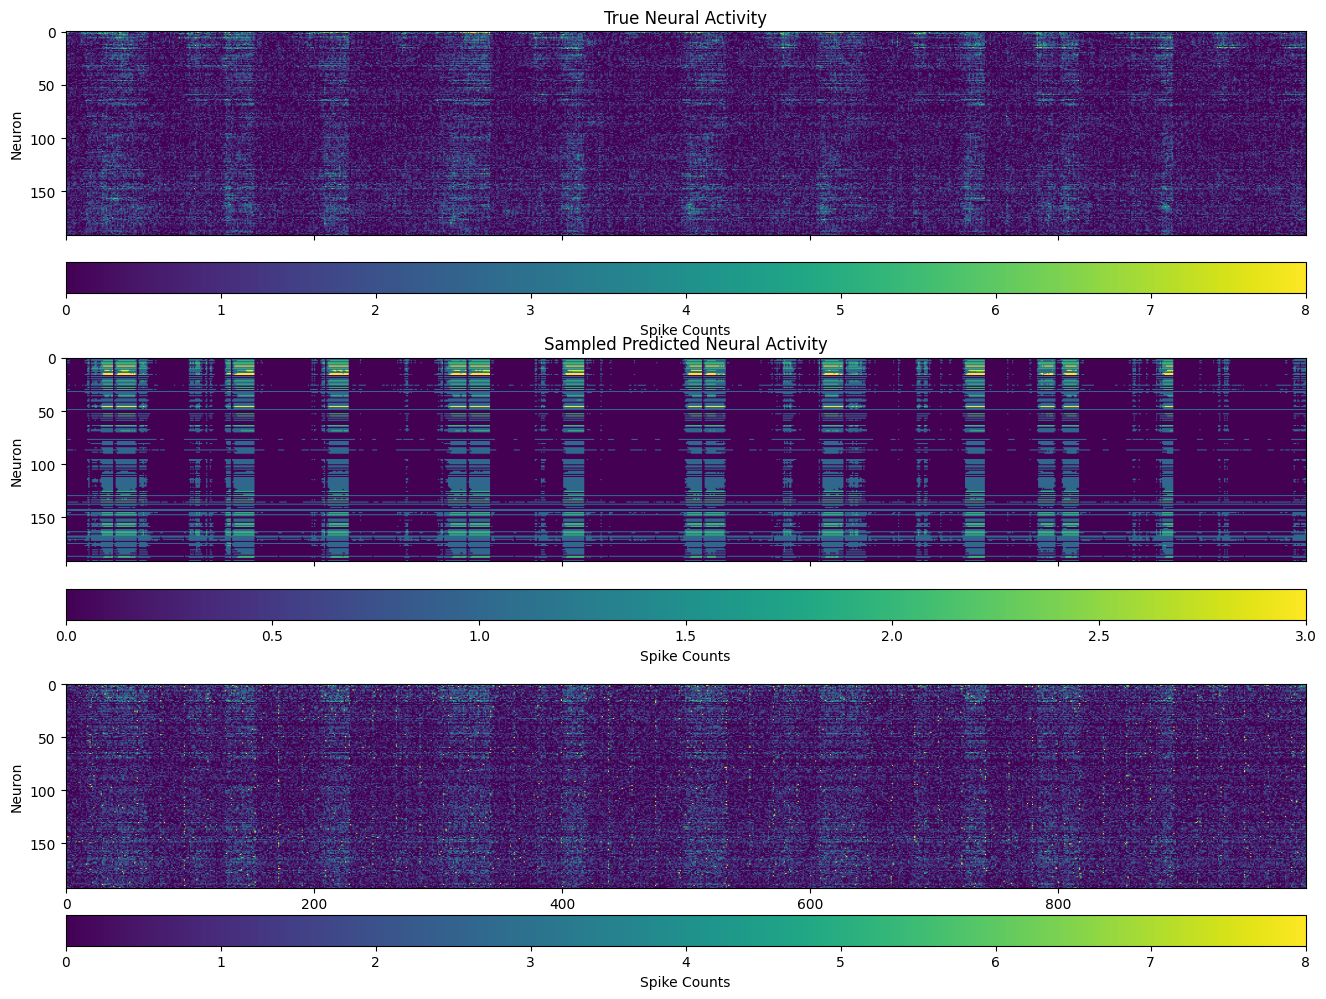

In [8]:
with torch.no_grad():
    # Prepare input data
    X_test_vis = X_test.transpose(1, 2)  # shape: (batch_size, n_context_bins, n_neurons+4)
    batch_X = X_test_vis[:, :-1, :]  # shape: (batch_size, n_context_bins-1, n_neurons+4)
    
    # Get model predictions
    outputs = model(batch_X)[:, :, :, :]  # Shape: (batch, n_context_bins-1, n_neurons, n_fr_bins)
    test_pred_probs = torch.softmax(outputs, dim=3)  # Get probabilities
    
    # Get both argmax and sampled predictions
    pred_classes = torch.argmax(outputs, dim=3).cpu().numpy()
    test_pred_sample = torch.multinomial(test_pred_probs.reshape(-1, n_fr_bins), 1)
    test_pred_sample = test_pred_sample.reshape(outputs.shape[0], outputs.shape[1], outputs.shape[2]).cpu().numpy()

# Convert dataset to numpy arrays and visualize
import matplotlib.pyplot as plt

# Create figure with subplots and shared x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), height_ratios=[1, 1, 1], sharex=True)

# Plot heatmap of true data
max_show_timesteps = 1000
true_data = X_test_vis[:, 1:, :n_neurons].cpu().numpy()  # Get ground truth from next timesteps
im0 = ax1.imshow(true_data.reshape(-1, n_neurons)[:max_show_timesteps, :].T, aspect='auto', cmap='viridis')
ax1.set_title('True Neural Activity')
ax1.set_ylabel('Neuron')
plt.colorbar(im0, ax=ax1, orientation='horizontal', pad=0.1, aspect=40, label='Spike Counts')

# Plot heatmap of argmax predictions
im1 = ax2.imshow(pred_classes.reshape(-1, n_neurons)[:max_show_timesteps, :].T, aspect='auto', cmap='viridis')
ax2.set_title('Argmax Predicted Neural Activity')
ax2.set_ylabel('Neuron')
plt.colorbar(im1, ax=ax2, orientation='horizontal', pad=0.1, aspect=40, label='Spike Counts')

# Plot heatmap of sampled predictions
im2 = ax3.imshow(test_pred_sample.reshape(-1, n_neurons)[:max_show_timesteps, :].T, aspect='auto', cmap='viridis')
ax2.set_title('Sampled Predicted Neural Activity')
ax3.set_ylabel('Neuron')
ax3.set_xlabel('Time Step')
plt.colorbar(im2, ax=ax3, orientation='horizontal', pad=0.1, aspect=40, label='Spike Counts')


In [9]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert dataset to PyTorch tensors and move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_test_unplug = []
for test_unplug_dataset in datasets[-4:]:
    for i in range(len(test_unplug_dataset)):
        features = test_unplug_dataset[i]
        X_test_unplug.append(features)
X_test_unplug_data = torch.cat(X_test_unplug, dim=1).to(device)


In [146]:
X_test_unplug_data = X_test_unplug_data[:, 100:]

In [11]:
model.eval()
X_test_unplug = X_test_unplug_data.clone().T
X_test_unplug[n_context_bins-1:, :n_neurons] = 0

temperature = 1  # Add temperature parameter (higher = more random, lower = more deterministic)

for i in range(n_context_bins-1, X_test_unplug.shape[0]):
    # Prepare input by transposing to (batch, context_bins, features)
    batch_X = X_test_unplug[i-n_context_bins+1:i].unsqueeze(0)  # shape: (1, n_context_bins-1, n_neurons+4)
    
    # Get model predictions
    outputs = model(batch_X)[:, :n_neurons, :, :]  # Shape: (1, n_context_bins-1, n_neurons, n_fr_bins)
    
    # Sample from probability distribution with temperature
    logits = outputs / temperature  # Apply temperature scaling
    pred_probs = torch.softmax(logits, dim=3)  # Get probabilities
    pred_sample = torch.multinomial(pred_probs.reshape(-1, n_fr_bins), 1)  # Sample from probabilities
    pred_sample = pred_sample.reshape(outputs.shape[0], outputs.shape[1], outputs.shape[2])
    
    # Update next timestep with predictions
    X_test_unplug[i, :n_neurons] = pred_sample[0, -1]

print(X_test_unplug.shape)


torch.Size([440, 196])


Text(0, 0.5, 'Neuron')

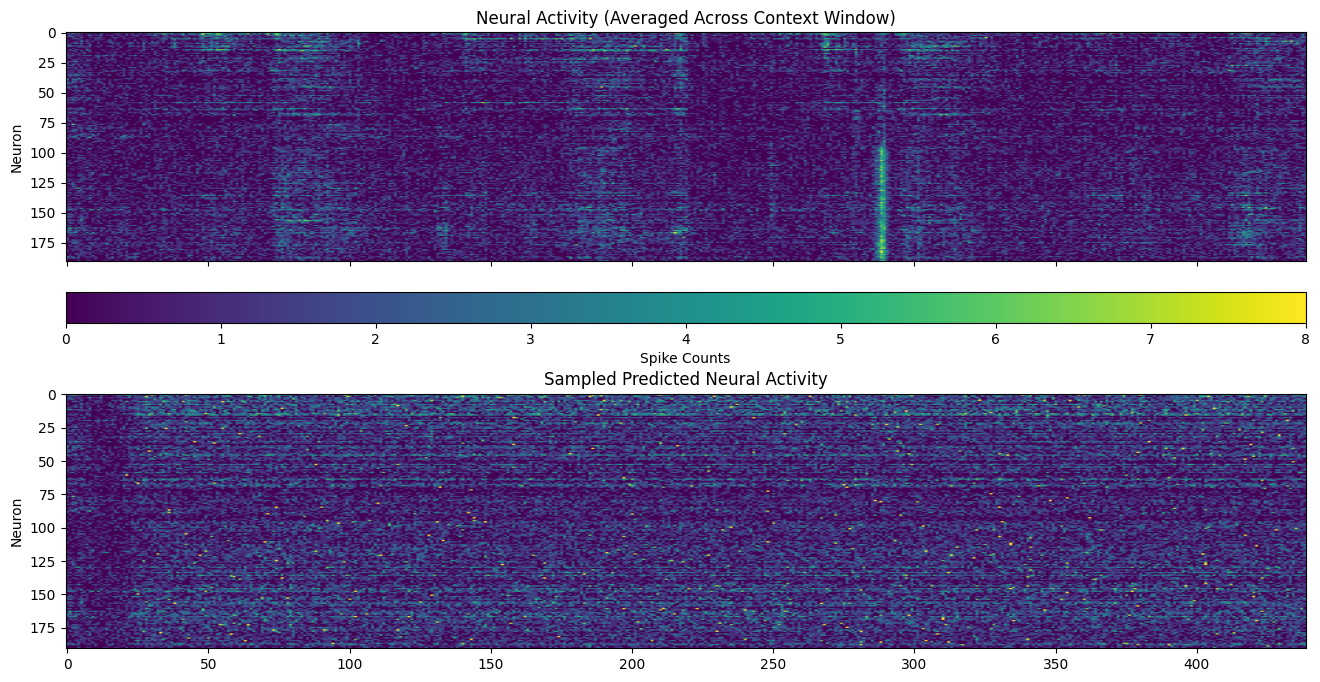

In [12]:
y_test_unplug = X_test_unplug_data.clone().T

# Convert dataset to numpy arrays and visualize
import matplotlib.pyplot as plt

# Create figure with subplots and shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), height_ratios=[1.2, 1], sharex=True)

# Plot heatmap of X
show_n_neurons = -1
show_n_timesteps = -1
im = ax1.imshow(y_test_unplug[:, :n_neurons][:show_n_timesteps, :show_n_neurons].T, aspect='auto', cmap='viridis')
ax1.set_title('Neural Activity (Averaged Across Context Window)')
ax1.set_ylabel('Neuron')
# Add smaller colorbar at the top
cbar = plt.colorbar(im, ax=ax1, orientation='horizontal', pad=0.1, aspect=40, label='Spike Counts')

im = ax2.imshow(X_test_unplug[:, :n_neurons][:show_n_timesteps, :show_n_neurons].T, aspect='auto', cmap='viridis')
ax2.set_title('Sampled Predicted Neural Activity')
ax2.set_ylabel('Neuron')


In [91]:
# Define model
input_size = n_neurons * n_context_bins
model_firstway = nn.Sequential(
    nn.Linear(input_size, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 2)
).to(device)

# Load the trained model
model_firstway.load_state_dict(torch.load(f'trained_mlp_model_{n_context_bins}.pth'))
model_firstway.eval()  # Set the model to evaluation mode

model_firstway_inputs = y_p

FileNotFoundError: [Errno 2] No such file or directory: 'trained_mlp_model_40.pth'